### Political Polarization Calculations using BHPS 2000 data

In [1]:
import pandas as pd
import os
import time
import numpy as np

In [2]:
os.chdir(r"C:\Users\Sidrcs\Documents\Github\Political_Polarization\data")

In [3]:
df_residence = pd.read_csv("jindresp.csv")

C:\Users\Sidrcs\anaconda3\envs\PySAL\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (6,7,29,879,880,993,1104,1156,1212,1216,1217) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Interested variables for visualization
Look for <code>jindresp.csv</code> | Required variables are: (These are columns names and their corresponding interpretation) <ul><li><code>jopsocc</code> : "Private enterprise is the best way to solve Britain’s economic problems" (S1)</li> <li><code>jopsocd</code> : "Major public services and industries ought to be in state ownership" (S2)</li> <li><code>jopsoce</code> : "It is the government’s responsibility to provide a job for everyone who wants one" (S3)</li> <li><code>jfiyr</code> : <b>Self-reported annual income</b> </li> <li><code>jfetype</code> : <b>Educational qualification</b></li> <li><code>jplbornc_cc</code> : <b>Country of birth</b></li> <li><code>jage12</code> : <b>Age</b></li> <li><code>jjbstatt</code> : <b>Employment status</b></li> <li><code>jregion2</code> : <b>UK region name</b> </li></ul>

In [4]:
# Loading variables of interest from 2000 BHPS dataset into dataframe
df_residence = df_residence[["jopsocc","jopsocd","jopsoce","jfiyr","jfetype","jage12","jjbstatt","jregion2", "jplbornc_cc"]]

In [5]:
# Dropping rows if they donot have any spatial information
df_residence = df_residence[~df_residence["jregion2"].isin(["don't know", "inapplicable", "missing or wild", "refused"])]

In [6]:
# To view columns
df_residence.head()

,jopsocc,jopsocd,jopsoce,jfiyr,jfetype,jage12,jjbstatt,jregion2,jplbornc_cc
0,Agree,Disagree,Disagree,30849.408203125,inapplicable,66.0,Self employed,London,inapplicable
1,Agree,Neither agree/disagree,Disagree,2553.462890625,inapplicable,63.0,Family care,London,inapplicable
2,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,45.0,proxy and/or phone,London,proxy and/or phone
3,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,19.0,proxy and/or phone,London,proxy and/or phone
4,Agree,Agree,Disagree,6754.79931640625,inapplicable,21.0,"FT studt, school",London,inapplicable


In [7]:
df_residence['jopsocc'].value_counts()

Neither agree/disagree    5819
Disagree                  4014
Agree                     3189
don't know                 873
Strongly disagree          579
proxy and/or phone         510
Strongly agree             429
Name: jopsocc, dtype: int64

In [20]:
# create an empty dataframe
output_df = pd.DataFrame()

# Group the dataframe by county and calculate standard deviation of age : "jage12"
output_df["Standard Deviation of Age"] = df_residence.groupby("jregion2")["jage12"].agg("std")

# Group the dataframe by county and number of people born in UK : "jplbornc_cc"
output_df["born"] = df_residence.groupby("jregion2")["jplbornc_cc"]

# Assuming inapplicable as people born in UK to all others
def native_share(x):
    pop_count = list(x["born"][1])
    native_count = pop_count.count("inapplicable")/len(pop_count)
    return native_count

# calculating fraction of natives in each county
output_df["Native Share Variability"] = output_df.apply(lambda x: native_share(x), axis = 1)

# Dropping "born" groupby column
output_df = output_df.drop(columns = ["born"], axis = 1)

# Creating afetype_dict based on PDF from 2000 BHPS data
jfetype_dict = {"Nursing school etc" : 1, "College of f educ" : 2, "Other trng establmnt" : 3, "Polytechnic" : 4, \
                "University" : 5, "None of the above" : 7, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy and/or phone" : -7, "refused" : -2}


# Create a new column "jfetype_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "jfetype_encoded"] = df_residence["jfetype"].replace(jfetype_dict)

# Group the dataframe by county and "jfetype_encoded"
output_df["education"] = df_residence.groupby("jregion2")["jfetype_encoded"]

# function to calculate dissimilarity in education
def dissimilarity_education(x):
    # loads tuple element into job
    job = x["education"][1]
    # loads frequency of each education type in county as list
    freq = list(job.value_counts())
    # calculates total number of groups
    s = len(freq)
    dissim_index = 0
    for i in freq:
        # formula of dissimilarity index
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

def region_name(x):
    return x["education"][0]

output_df["Education Variability"] = output_df.apply(lambda x: dissimilarity_education(x), axis = 1)
output_df["region_name"] = output_df.apply(lambda x: region_name(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["education"], axis = 1)

# Creating ajbstatt_dict based on PDF from 2000 BHPS data
jjbstatt_dict = {"Self employed" : 1, "In paid employ" : 2, "Unemployed" : 3, "Retired" : 4, "Maternity leave" : 5, \
                    "Family care" : 6,  "FT studt, school" : 7, " LT sick, disabld" : 8, \
                    "Govt trng scheme" : 9, "Something else" : 10, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy" : -7, "refused" : -2}


# Create a new column "jjbstatt_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "jjbstatt_encoded"] = df_residence["jjbstatt"].replace(jjbstatt_dict)

# Group the dataframe by county and calculate the mean and standard deviation of the encoded values
output_df["job"] = df_residence.groupby("jregion2")["jjbstatt_encoded"]

# function to calculate dissimilarity in job
def dissimilarity_job(x):
    job = x["job"][1]
    freq = list(job.value_counts())
    s = len(freq)
    dissim_index = 0
    for i in freq:
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

# function to calculate fraction of employed people within each county
def frac_employed(x):
    job = list(x["job"][1])
    frac_emp = (job.count(2)/len(job))
    return frac_emp

output_df["Job Variability"] = output_df.apply(lambda x: dissimilarity_job(x), axis = 1)
output_df ["Fraction of Employed"] = output_df.apply(lambda x: frac_employed(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["job"], axis = 1)

# replacing all Not-A-Number cases to zero i.e., proxy values
df_residence.loc[:, "jfiyr"] = df_residence["jfiyr"].replace("proxy and/or phone",0).astype("float32")

# Group the dataframe by county and calculate median based on self-reported annual income: "jfiyr"
output_df["Median Income"] = df_residence.groupby("jregion2")["jfiyr"].agg(["median"])

# convert "jfiyr" column to float data type
df_residence["jfiyr"] = df_residence["jfiyr"].astype("float32")

# group incomes by county
output_df["income"] = df_residence.groupby("jregion2")["jfiyr"]

def gini_index(x):
    data = list(x["income"][1])
    # sort the data in ascending order
    sorted_data = np.sort(data)
    # calculate the cumulative sum of the sorted data
    cumsum_data = np.cumsum(sorted_data)
    # calculate the Lorenz curve values
    lorenz_curve = cumsum_data / cumsum_data[-1]
    # calculate the area under the Lorenz curve
    area_lorenz_curve = np.trapz(lorenz_curve, dx=1/len(data))
    # calculate the Gini index
    gini_index = 1 - 2 * area_lorenz_curve
    return gini_index

output_df["Gini Index of Income Inequality"] = output_df.apply(lambda x : gini_index(x), axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["income"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Inequality
jregion2,,,,,,,,
East Midlands,17.689591,1.000000,403.5,East Midlands,403.5,0.556931,9672.677734,0.417944
East of England,18.364262,0.998818,422.5,East of England,422.5,0.535461,10500.000000,0.469766
London,17.943167,0.981971,415.5,London,415.5,0.562500,12498.041016,0.468434
North East,18.425357,0.997768,223.5,North East,223.5,0.508929,8964.774414,0.444436
North West,18.031359,0.999102,556.5,North West,556.5,0.533214,10194.762695,0.438706
Scotland,17.803128,0.991580,1543.5,Scotland,1543.5,0.518459,9310.974609,0.437523
South East,17.999943,0.995509,667.5,South East,667.5,0.557635,10904.890625,0.432784
South West,18.630622,0.993119,435.5,South West,435.5,0.525229,9564.146484,0.447468
Wales,17.943682,0.996180,1308.5,Wales,1308.5,0.448434,8919.899414,0.443795


In [21]:
# Define the dictionary to encode the "jopsocc" column which is Statement 1 (S1)
# S1: "Private enterprise is the best way to solve Britain’s economic problems."
jopsocc_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

In [22]:
# Create a new column "jopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
#df_residence["jopsocc_encoded"] = df_residence["jopsocc"].replace(jopsocc_dict)
df_residence.loc[:, "jopsocc_encoded"] = df_residence["jopsocc"].replace(jopsocc_dict)

df_residence["jopsocc_encoded"].value_counts()

 0    5697
-1    3892
 1    3122
-2     563
 2     425
Name: jopsocc_encoded, dtype: int64

In [23]:
# Define the dictionary to encode the "jopsocc" column which is Statement 1 (S1)
# S1: "Private enterprise is the best way to solve Britain’s economic problems."
jopsocc_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}


# Create a new column "jopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
#df_residence["jopsocc_encoded"] = df_residence["jopsocc"].replace(jopsocc_dict)
df_residence.loc[:, "jopsocc_encoded"] = df_residence["jopsocc"].replace(jopsocc_dict)

#remove -3 valued rows from df_residence[jopsocc_encoded]
df_residence = df_residence[df_residence['jopsocc_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S1"] = df_residence.groupby("jregion2")["jopsocc_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("jregion2")["jopsocc_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("jregion2")["jopsocc_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S1"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and jopsocc_encoded values
output_df["dkp"] = df_residence.groupby("jregion2")["jopsocc_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S1"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1
jregion2,,,,,,,,,,,
East Midlands,17.689591,1.000000,403.5,East Midlands,403.5,0.556931,9672.677734,0.417944,0.676345,0.580446,0.996544
East of England,18.364262,0.998818,422.5,East of England,422.5,0.535461,10500.000000,0.469766,0.745552,0.618203,1.030585
London,17.943167,0.981971,415.5,London,415.5,0.562500,12498.041016,0.468434,0.822960,0.682692,2.210048
North East,18.425357,0.997768,223.5,North East,223.5,0.508929,8964.774414,0.444436,0.767338,0.660714,0.600031
North West,18.031359,0.999102,556.5,North West,556.5,0.533214,10194.762695,0.438706,0.833392,0.657092,2.760184
Scotland,17.803128,0.991580,1543.5,Scotland,1543.5,0.518459,9310.974609,0.437523,0.825967,0.700130,1.635783
South East,17.999943,0.995509,667.5,South East,667.5,0.557635,10904.890625,0.432784,0.646805,0.568114,0.439960
South West,18.630622,0.993119,435.5,South West,435.5,0.525229,9564.146484,0.447468,0.766908,0.630734,2.310216
Wales,17.943682,0.996180,1308.5,Wales,1308.5,0.448434,8919.899414,0.443795,0.880457,0.719251,2.448600


In [24]:
# Define the dictionary to encode the "jopsocd" column which is Statement 2 (S2)
# S2: "Major public services and industries ought to be in state ownership."

jopsocd_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "jopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
#df_residence["jopsocd_encoded"] = df_residence["jopsocd"].replace(jopsocd_dict)
df_residence.loc[:, "jopsocd_encoded"] = df_residence["jopsocd"].replace(jopsocd_dict)

#remove -3 valued rows from df_residence[jopsocc_encoded]
df_residence = df_residence[df_residence['jopsocd_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S2"] = df_residence.groupby("jregion2")["jopsocd_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("jregion2")["jopsocd_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("jregion2")["jopsocd_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S2"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and jopsocc_encoded values
output_df["dkp"] = df_residence.groupby("jregion2")["jopsocd_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S2"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

In [25]:
# Define the dictionary to encode the "jopsocd" column which is Statement 3 (S3)
# S3: "It is the government’s responsibility to provide a job for everyone who wants one."

jopsoce_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "jopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
#df_residence["jopsoce_encoded"] = df_residence["jopsoce"].replace(jopsoce_dict)
df_residence.loc[:, "jopsoce_encoded"] = df_residence["jopsoce"].replace(jopsoce_dict)

#remove -3 valued rows from df_residence[jopsocc_encoded]
df_residence = df_residence[df_residence['jopsoce_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S3"] = df_residence.groupby("jregion2")["jopsoce_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("jregion2")["jopsoce_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("jregion2")["jopsoce_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S3"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and eopsocc_encoded values
output_df["dkp"] = df_residence.groupby("jregion2")["jopsoce_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S3"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
jregion2,,,,,,,,,,,,,,,,,
East Midlands,17.689591,1.000000,403.5,East Midlands,403.5,0.556931,9672.677734,0.417944,0.676345,0.580446,0.996544,0.880365,0.724010,1.424538,1.105940,0.926980,1.983359
East of England,18.364262,0.998818,422.5,East of England,422.5,0.535461,10500.000000,0.469766,0.745552,0.618203,1.030585,0.890720,0.722222,4.746276,1.055868,0.877069,2.056166
London,17.943167,0.981971,415.5,London,415.5,0.562500,12498.041016,0.468434,0.822960,0.682692,2.210048,0.987313,0.788462,3.331684,1.160025,0.937500,5.162416
North East,18.425357,0.997768,223.5,North East,223.5,0.508929,8964.774414,0.444436,0.767338,0.660714,0.600031,0.955132,0.770089,4.428563,1.141374,1.002232,0.817068
North West,18.031359,0.999102,556.5,North West,556.5,0.533214,10194.762695,0.438706,0.833392,0.657092,2.760184,0.962773,0.762118,3.409985,1.162476,0.972172,2.838004
Scotland,17.803128,0.991580,1543.5,Scotland,1543.5,0.518459,9310.974609,0.437523,0.825967,0.700130,1.635783,0.973092,0.790479,1.899963,1.125558,0.965997,1.349256
South East,17.999943,0.995509,667.5,South East,667.5,0.557635,10904.890625,0.432784,0.646805,0.568114,0.439960,0.909609,0.746257,1.979545,1.095113,0.894461,5.264233
South West,18.630622,0.993119,435.5,South West,435.5,0.525229,9564.146484,0.447468,0.766908,0.630734,2.310216,0.960963,0.748853,4.520324,1.061933,0.881881,3.028365
Wales,17.943682,0.996180,1308.5,Wales,1308.5,0.448434,8919.899414,0.443795,0.880457,0.719251,2.448600,1.044927,0.848739,2.113801,1.170458,0.983193,3.074358


In [26]:
output_df.reset_index(drop=True, inplace=True)
output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,17.689591,1.000000,403.5,East Midlands,403.5,0.556931,9672.677734,0.417944,0.676345,0.580446,0.996544,0.880365,0.724010,1.424538,1.105940,0.926980,1.983359
1,18.364262,0.998818,422.5,East of England,422.5,0.535461,10500.000000,0.469766,0.745552,0.618203,1.030585,0.890720,0.722222,4.746276,1.055868,0.877069,2.056166
2,17.943167,0.981971,415.5,London,415.5,0.562500,12498.041016,0.468434,0.822960,0.682692,2.210048,0.987313,0.788462,3.331684,1.160025,0.937500,5.162416
3,18.425357,0.997768,223.5,North East,223.5,0.508929,8964.774414,0.444436,0.767338,0.660714,0.600031,0.955132,0.770089,4.428563,1.141374,1.002232,0.817068
4,18.031359,0.999102,556.5,North West,556.5,0.533214,10194.762695,0.438706,0.833392,0.657092,2.760184,0.962773,0.762118,3.409985,1.162476,0.972172,2.838004
5,17.803128,0.991580,1543.5,Scotland,1543.5,0.518459,9310.974609,0.437523,0.825967,0.700130,1.635783,0.973092,0.790479,1.899963,1.125558,0.965997,1.349256
6,17.999943,0.995509,667.5,South East,667.5,0.557635,10904.890625,0.432784,0.646805,0.568114,0.439960,0.909609,0.746257,1.979545,1.095113,0.894461,5.264233
7,18.630622,0.993119,435.5,South West,435.5,0.525229,9564.146484,0.447468,0.766908,0.630734,2.310216,0.960963,0.748853,4.520324,1.061933,0.881881,3.028365
8,17.943682,0.996180,1308.5,Wales,1308.5,0.448434,8919.899414,0.443795,0.880457,0.719251,2.448600,1.044927,0.848739,2.113801,1.170458,0.983193,3.074358
9,18.727401,0.995327,427.5,West Midlands,427.5,0.528037,9002.763672,0.429715,0.735179,0.613318,1.459928,0.950648,0.761682,2.019232,1.152402,0.960280,2.401548


In [27]:
corr_df = output_df.corr()
corr_df.to_csv("correlation_2000.csv")
corr_df

,Standard Deviation of Age,Native Share Variability,Education Variability,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
Standard Deviation of Age,1.000000,0.136261,-0.498931,-0.498931,-0.147257,-0.314704,0.168394,-0.168727,-0.226275,-0.064797,-0.083333,-0.266276,0.456568,-0.303799,-0.203646,-0.168961
Native Share Variability,0.136261,1.000000,-0.153163,-0.153163,-0.271144,-0.626738,-0.496779,-0.375430,-0.440928,-0.323539,-0.471808,-0.406960,-0.090842,-0.310933,-0.044036,-0.503552
Education Variability,-0.498931,-0.153163,1.000000,1.000000,-0.473488,-0.231558,-0.109964,0.509459,0.588883,0.290590,0.535886,0.660165,-0.414391,0.277777,0.307406,-0.074517
Job Variability,-0.498931,-0.153163,1.000000,1.000000,-0.473488,-0.231558,-0.109964,0.509459,0.588883,0.290590,0.535886,0.660165,-0.414391,0.277777,0.307406,-0.074517
Fraction of Employed,-0.147257,-0.271144,-0.473488,-0.473488,1.000000,0.684675,0.040118,-0.481234,-0.520365,-0.296344,-0.568958,-0.601718,0.091444,-0.139402,-0.374076,0.325248
Median Income,-0.314704,-0.626738,-0.231558,-0.231558,0.684675,1.000000,0.554928,-0.009572,-0.049306,0.079218,-0.077923,-0.103369,0.213829,0.064373,-0.315134,0.716739
Gini Index of Income Inequality,0.168394,-0.496779,-0.109964,-0.109964,0.040118,0.554928,1.000000,0.428259,0.404792,0.230855,0.244489,0.153349,0.721279,-0.039106,-0.178174,0.206909
Lindqvist_Ostling_S1,-0.168727,-0.375430,0.509459,0.509459,-0.481234,-0.009572,0.428259,1.000000,0.961233,0.761489,0.873800,0.805658,0.263487,0.633012,0.600341,-0.133519
Abramowitz_Saunders_S1,-0.226275,-0.440928,0.588883,0.588883,-0.520365,-0.049306,0.404792,0.961233,1.000000,0.603879,0.884505,0.865019,0.190307,0.626332,0.654659,-0.177784
Duca_Saving_S1,-0.064797,-0.323539,0.290590,0.290590,-0.296344,0.079218,0.230855,0.761489,0.603879,1.000000,0.673943,0.503184,0.107811,0.379839,0.209500,0.173645


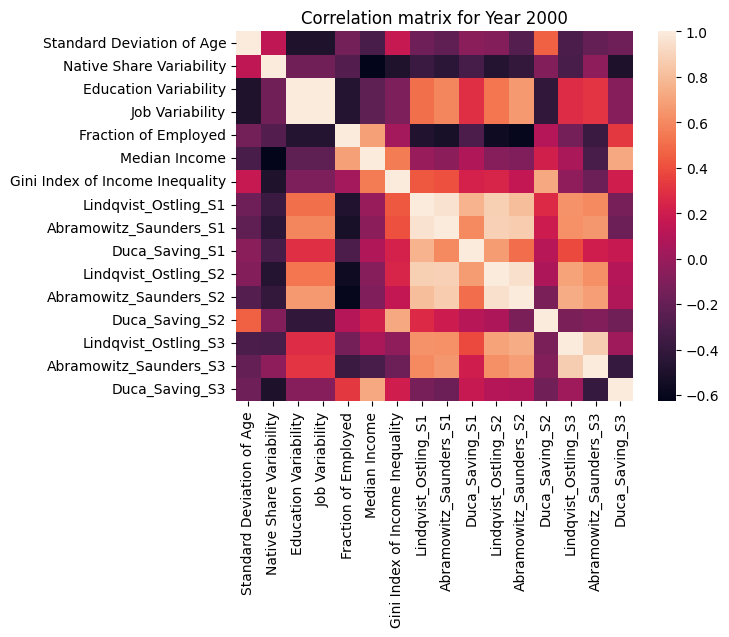

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = output_df.corr()
sns.heatmap(corr_matrix)
plt.title("Correlation matrix for Year 2000")
plt.show()

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 2000')

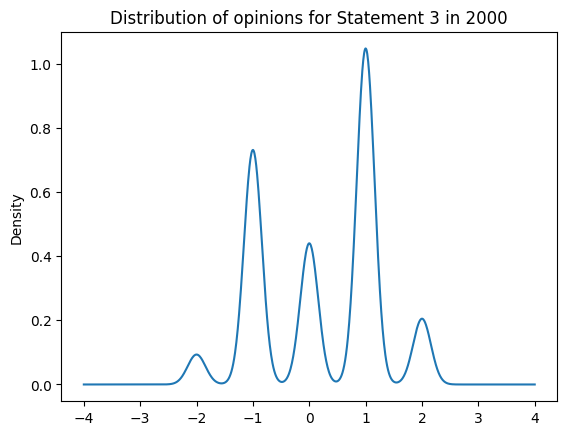

In [17]:
df_residence["jopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 2000")

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 2000')

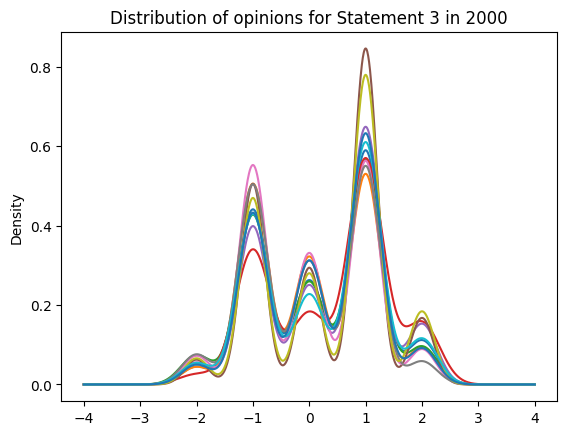

In [18]:
kde_df = df_residence.groupby("jregion2")["jopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 2000")

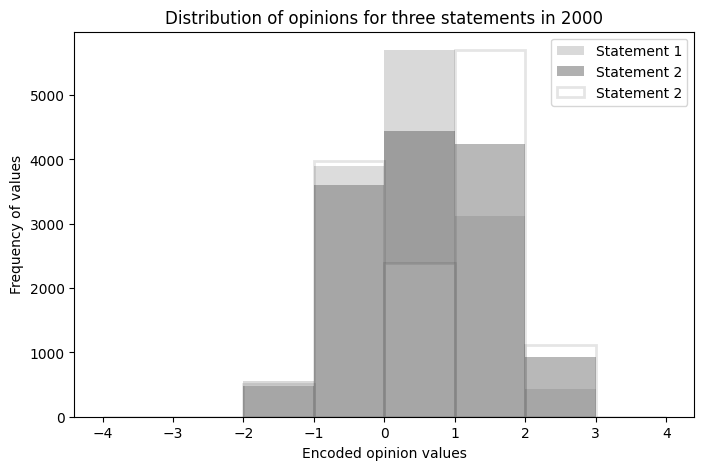

In [19]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(df_residence["jopsocc_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#d9d9d9')
ax.hist(df_residence["jopsocd_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#636363', alpha = 0.5)
ax.hist(df_residence["jopsoce_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='white', alpha = 0.1, edgecolor='black', linewidth = 2)

# set title and axis labels
ax.set_title('Distribution of opinions for three statements in 2000')
ax.set_xlabel('Encoded opinion values')
ax.set_ylabel('Frequency of values')

# add a legend
ax.legend(['Statement 1', 'Statement 2', 'Statement 2'], loc='upper right')

plt.show()

In [ ]:
output_df.to_csv("polarization2000_data.csv")